# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Number of features",feat_info.shape[0])

feat_info.head()

Number of features 85


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.shape

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
missing_or_unknown = zip(feat_info['attribute'],feat_info['missing_or_unknown'].str.strip('][').str.split(','))


In [8]:
for attribute,missing_values in missing_or_unknown:
    if len(missing_values) > 0:
        results = [int(i) if i.lstrip('-').isdigit() else i for i in missing_values]
        azdias[attribute] = azdias[attribute].replace(results,np.nan)
    

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

nan_columns = azdias.isna().sum()
nan_columns = nan_columns[nan_columns != 0]


In [10]:
print('Total missing {}'.format(nan_columns.sum()))

Total missing 8373929


In [11]:
print('Missing data per column\n')
print(nan_columns.sort_values())

Missing data per column

ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GFK_URLAUBERTYP            4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
HH_EINKOMMEN_SCORE        18348
ANZ_PERSONEN              73499
SOHO_KZ                   73499
ANZ_TITEL                 73499
WOHNDAUER_2008            73499
KONSUMNAEHE               73969
LP_FAMILIE_GROB           77792
LP_FAMILIE_FEIN           77792
GEBAEUDETYP               93148
WOHNLAGE                  93148
OST_WEST_KZ               93148
MIN_GEBAEUDEJAHR          93148
GEBAEUDETYP_RASTER        93155
EWDICHTE                  93740
BALLRAUM                  93740
INNENSTADT                93740
LP_LEBENSPHASE_GROB       94572
ANZ_HH_TITEL              97008
ORTSGR_KLS9               97274
ARBEIT                    97375
RELAT_AB                  97375
LP_LEBENSPHASE_FEIN       97632
CAMEO_DEUG_2015           99352
               

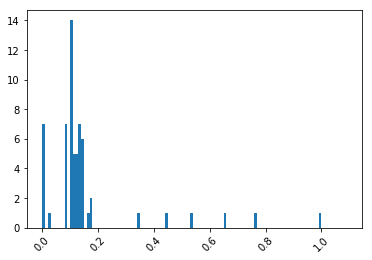

In [12]:
# Investigate patterns in the amount of missing data in each column.

percentage_of_columns = nan_columns / azdias.shape[0]
bin_size = np.arange(0,1.1,0.01)
plt.hist(percentage_of_columns,bins=bin_size)
plt.xticks(rotation=45)
plt.show()

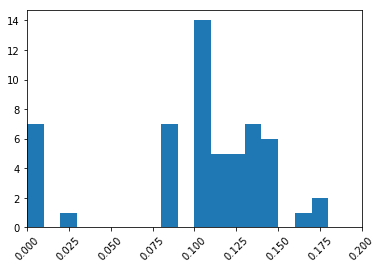

In [13]:
percentage_of_columns = nan_columns / azdias.shape[0]
bin_size = np.arange(0,1.1,0.01)
plt.hist(percentage_of_columns,bins=bin_size)
plt.xticks(rotation=45)
plt.xlim(0,0.2)
plt.show()

In [14]:
percentage_of_columns.head()

AGER_TYP                0.769554
ALTERSKATEGORIE_GROB    0.003233
CJT_GESAMTTYP           0.005446
GEBURTSJAHR             0.440203
GFK_URLAUBERTYP         0.005446
dtype: float64

In [15]:
columns_less_nineteen = percentage_of_columns[percentage_of_columns < 0.19]
columns_greater_nineteen = percentage_of_columns[percentage_of_columns > 0.19]
print("We have {} columns that have values below 19% of our data".format(len(columns_less_nineteen)))
print("We have {} columns that have values above 19% of our data, and can be considered as outliers".format(len(columns_greater_nineteen)))

We have 55 columns that have values below 19% of our data
We have 6 columns that have values above 19% of our data, and can be considered as outliers


In [16]:
print('Outlier columns\n')
columns_greater_nineteen

Outlier columns



AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
ALTER_HH        0.348137
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(columns_greater_nineteen.index,axis=1,inplace=True)
azdias.shape

(891221, 79)

In [18]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column


While analysing the data, it was found that there were 8,373,929 missing values in the dataset, also after further analysis it was discovered that 6 out of 85 columns were outliers as these had values very different from the average. These 6 columns are:

<table>
    <thead>
        <tr>
            <th>Column Name</th>
            <th>Description</th>
            <th>Total Values</th>
            <th>Missing Values</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>AGER_TYP</td>
            <td>Age Classification</td>
            <td>205,378</td>
            <td>685,843</td>
        </tr>
        <tr>
            <td>GEBURTSJAHR</td>
            <td>Year of birth</td>
            <td>498,903</td>
            <td>392,318</td>
        </tr>
        <tr>
            <td>TITEL_KZ</td>
            <td>Academic Title</td>
            <td>2,160</td>
            <td>889,061</td>
        </tr>
        <tr>
            <td>ALTER_HH</td>
            <td>birthdate of head of household</td>
            <td>580,954</td>
            <td>310,267</td>
        </tr>
        <tr>
            <td>kk_kundentyp</td>
            <td>customer pattern over past 12 months</td>
            <td>306,609</td>
            <td>584,612</td>
        </tr>
        <tr>
            <td>KBA05_BAUMAX</td>
            <td>Most common building type within the microcell</td>
            <td>414,697</td>
            <td>476,524</td>
        </tr>
    </tbody>
</table>


There are patterns in the missing data, while analyzing I found out that the first group was the following

CJT_GESAMTTYP             , 4854

GFK_URLAUBERTYP           , 4854

ONLINE_AFFINITAET         , 4854

RETOURTYP_BK_S            , 4854

LP_STATUS_FEIN            , 4854

LP_STATUS_GROB            , 4854

It can be seen that this particular group has same number of missing data, While further analyzing this group I found out that all of these columns belong to categorizing customer data like preferred buying channels,vacation habits,online afinity etc.

I also had a look at 2 more patterns these are the following

ANZ_PERSONEN             , 73499

SOHO_KZ                  , 73499

ANZ_TITEL                , 73499

WOHNDAUER_2008           , 73499

and


LP_FAMILIE_GROB          , 77792

LP_FAMILIE_FEIN          , 77792

While analysing these 2 groups, i found out that the first group holds information related to household, and the second pattern of missing data includes information related to family type


In [19]:
print('Missing data after removing outliers',azdias.isna().sum().sum())

Missing data after removing outliers 5035304


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
missing_value_rows = azdias.isna().sum(axis=1)
missing_value_rows_cleaned = missing_value_rows[missing_value_rows != 0]
print("Total values missing in all dataset",missing_value_rows_cleaned.sum())
print("Count of rows that have missing values are",missing_value_rows_cleaned.count())
print("Rows that donot have missing values are", azdias.shape[0] - missing_value_rows_cleaned.shape[0])

Total values missing in all dataset 5035304
Count of rows that have missing values are 268012
Rows that donot have missing values are 623209


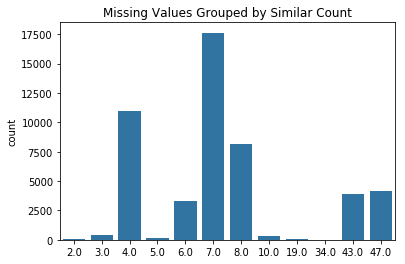

In [21]:
default_color = sns.color_palette()[0]
sns.countplot(x=missing_value_rows_cleaned.values,data=missing_value_rows_cleaned,color=default_color)
plt.title('Missing Values Grouped by Similar Count')
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 9
subset1_index = missing_value_rows[missing_value_rows < threshold].index
subset2_index = missing_value_rows[missing_value_rows >= threshold].index

subset1 = azdias.loc[subset1_index]
subset2 = azdias.loc[subset2_index]

print('subset 1 has {} rows'.format(subset1.shape[0]))
print('subset 2 has {} rows'.format(subset2.shape[0]))

subset 1 has 771701 rows
subset 2 has 119520 rows


In [23]:
def compare_subsets(subset_1,subset_2,column_to_compare):   
    default_color = sns.color_palette()[0]
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.countplot(x=subset_1[column_to_compare],data=subset_1,color=default_color)
    plt.title('No or Few Missing Values (SubSet 1)')
    plt.subplot(1,2,2)
    sns.countplot(x=subset_2[column_to_compare],data=subset_2,color=default_color)
    plt.title('Many Missing Values (Subset 2)')
    plt.tight_layout()
    plt.show()


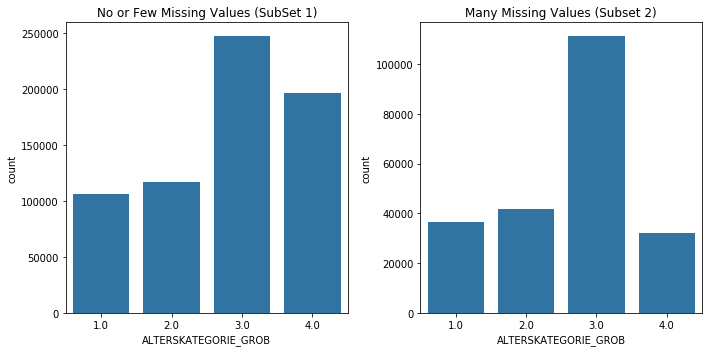

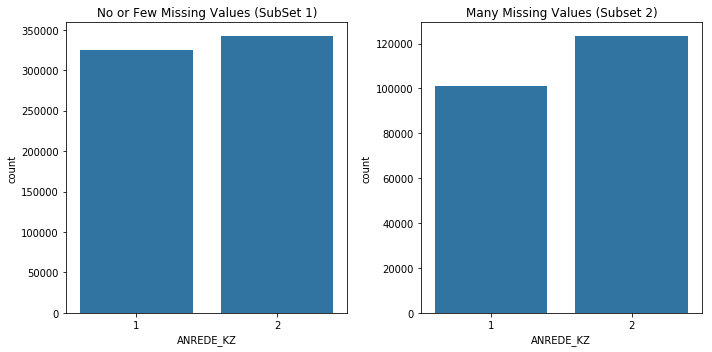

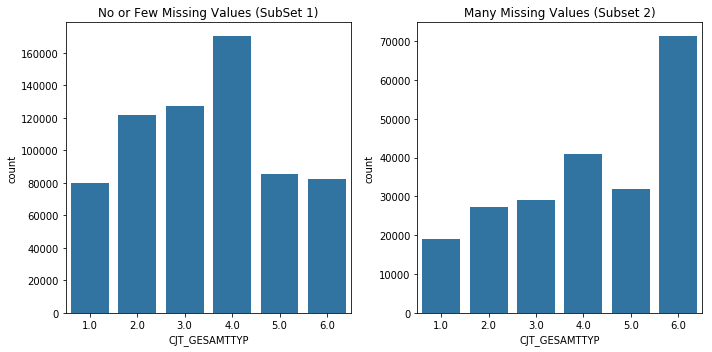

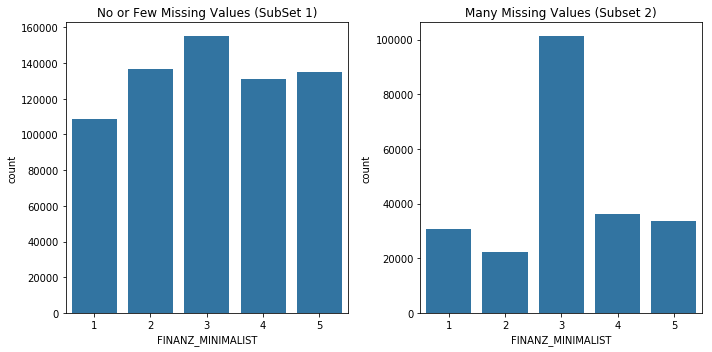

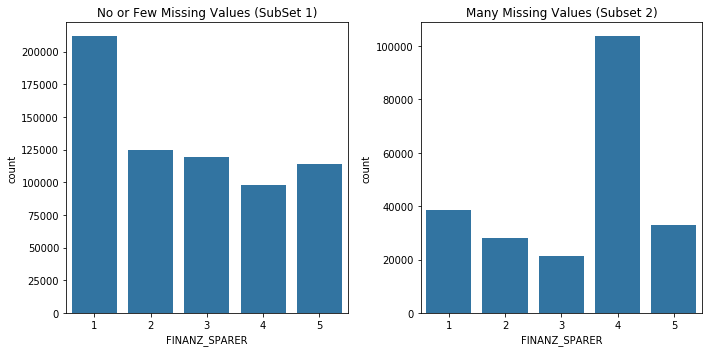

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

test_columns = azdias.columns[:5]
for col in test_columns:
    compare_subsets(subset1,subset2,col)

#### Discussion 1.1.3: Assess Missing Data in Each Row


There are 268,012 rows that have missing values, and 623,209 rows that don't have missing values. After analyzing the visualization at step 2 of this section, it turns out that 9 seems to be good center point between the two subsets, and it peaks at 7 showing that most rows have around 7 missing values.

After visualizing the graphs in the above step, the first 2 columns are qualitatively similar even after the huge difference between the subset data, for column 3 "CTJ_GESAMTTYP" there is slight difference in the data as as it seem to hold more of 6 values, for the remaining two columns, there is slight difference between the graphs but it might be because subset 1 has more data than subset 2


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info_cleaned = feat_info[~feat_info.attribute.isin(columns_greater_nineteen.index)]
feat_info_cleaned.groupby(['type']).size()

type
categorical    18
mixed           6
numeric         6
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

attributes_to_encode = []
categorical_features = feat_info_cleaned.query('type == "categorical"')

for category in categorical_features.values:
    missing_value = category[3]
    missing_value = missing_value.replace('[','')
    missing_value = missing_value.replace(']','')
    result = missing_value.split(',')
    for value in result:
        if not value.lstrip('-').isdigit() and len(value) > 0:
            attributes_to_encode.append(category[0])

In [26]:
print('The Features that need encoding are\n')
for col_name in attributes_to_encode:
    print(col_name)

The Features that need encoding are

CAMEO_DEUG_2015
CAMEO_DEU_2015


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_encoded = azdias
for col_name in attributes_to_encode:
    df = pd.get_dummies(azdias[col_name],prefix=col_name)
    azdias_encoded = pd.concat((azdias_encoded,df),axis=1)
    azdias_encoded.drop(col_name,axis=1,inplace=True)


In [28]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,1,2.0,3,4,3,5,5,3,4,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,0,0,0,0,0


In [29]:
azdias_encoded.shape

(891221, 130)

In [30]:
# verifying if there are other columns that are multi-level categorical
for attribute in categorical_features.values:
    unique_values = azdias[attribute[0]].unique()
    if len(unique_values) > 2:
        print(attribute[0],unique_values)

CJT_GESAMTTYP [  2.   5.   3.   4.   1.   6.  nan]
FINANZTYP [4 1 6 5 2 3]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
LP_FAMILIE_FEIN [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
LP_FAMILIE_GROB [  2.   3.   1.  nan   5.   4.]
LP_STATUS_FEIN [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [ nan   1.   3.   2.]
SHOPPER_TYP [ nan   3.   2.   1.   0.]
SOHO_KZ [ nan   1.   0.]
VERS_TYP [ nan   2.   1.]
ZABEOTYP [3 5 4 1 6 2]
GEBAEUDETYP [ nan   8.   1.   3.   2.   6.   4.   5.]
OST_WEST_KZ [nan 'W' 'O']
CAMEO_DEUG_2015 [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [31]:
#re-encoding after further analysis

azdias_encoded[['OST_WEST_KZ_O','OST_WEST_KZ_W']] = pd.get_dummies(azdias_encoded['OST_WEST_KZ'],prefix='OST_WEST_KZ')
azdias_encoded.drop(['OST_WEST_KZ'],axis=1,inplace=True)

azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,2.0,1,2.0,3,4,3,5,5,3,4,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,0,0,0,0,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,0,0,0,0,1
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,0,0,0,0,1
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,0,0,0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

After looking at the features info table, I found 18 categorical values, out of which 2 had Alphabet character in its "missing or unknown values" column. Also when looking at the column details in data_dictionary, i found out that one of the selected 2 columns was holding alphanumeric values. And both were multi-level categorical as they had values more than 2

First i removed the outliers from feat_info dataframe because they were removed earlier, then i checked the quantity of categorical features that are present, then i checked each feature and its missing values column, and checked if the values were binary or if it contained any character; I found 2 features that contained character in its missing values, so i hot encoded them using pandas get_dummies and saved them under modified dataframe, then I removed the existing column that were originally not encoded.

Also after further analyzing the features, i found out that the column called "OST_WEST_KZ" had categorical values and not numerical, so I went on and converted them to numerical and dropped the column from the dataframe

Also i left the remaining multi-level categorical features as they are, I might revisit it if the results of my model are not accurate

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_info_cleaned.query('attribute == "PRAEGENDE_JUGENDJAHRE"')

,attribute,information_level,type,missing_or_unknown
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"


In [33]:
azdias_encoded['PRAEGENDE_JUGENDJAHRE'].unique()

array([ nan,  14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,
         2.,   1.,  12.,  13.,   7.])

In [34]:
'''
Decades: 
    40s - 1
    50s - 2
    60s - 3
    70s - 4
    80s - 5
    90s - 6

Binary Values for movement
    MainStream - 0
    Avantgarde - 1

'''

decade_classes = {
    1 : 1,
    2 : 1,
    3 : 2,
    4 : 2,
    5 : 3,
    6 : 3,
    7 : 3,
    8 : 4,
    9 : 4,
    10 : 5,
    11 : 5,
    12 : 5,
    13 : 5,
    14 : 6,
    15 : 6
}


movement_classes = {
    1 : 0,
    2 : 1,
    3 : 0,
    4 : 1,
    5 : 0,
    6 : 1,
    7 : 1,
    8 : 0,
    9 : 1,
    10 : 0,
    11 : 1,
    12 : 0,
    13 : 1,
    14 : 0,
    15 : 1
}



In [35]:
azdias_encoded['decade'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(decade_classes)
azdias_encoded['movement'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_classes)
azdias_encoded.drop(['PRAEGENDE_JUGENDJAHRE'],axis=1,inplace=True)

azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement
0,2.0,1,2.0,3,4,3,5,5,3,4,...,0,0,0,0,0,0,0,0,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,0,0,1,6.0,0.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,0,0,1,6.0,1.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,0,0,1,4.0,0.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,0,0,1,4.0,0.0


In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
feat_info_cleaned.query('attribute == "CAMEO_INTL_2015"')

,attribute,information_level,type,missing_or_unknown
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [37]:
azdias_encoded['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [38]:
azdias_encoded['CAMEO_INTL_2015_TENS'] = azdias_encoded['CAMEO_INTL_2015'].str[0]
azdias_encoded['CAMEO_INTL_2015_ONES'] = azdias_encoded['CAMEO_INTL_2015'].str[1]
azdias_encoded.drop(['CAMEO_INTL_2015'],axis=1,inplace=True)
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,2.0,1,2.0,3,4,3,5,5,3,4,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,1,6.0,0.0,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,1,6.0,1.0,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,1,4.0,0.0,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,1,4.0,0.0,4,3


In [39]:
feat_info_cleaned.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [40]:
azdias_encoded['LP_LEBENSPHASE_FEIN'].unique()

array([ 15.,  21.,   3.,  nan,  32.,   8.,   2.,   5.,  10.,   4.,   6.,
        23.,  12.,  20.,   1.,  11.,  25.,  13.,   7.,  18.,  31.,  19.,
        38.,  35.,  30.,  22.,  14.,  33.,  29.,  24.,  28.,  37.,  26.,
        39.,  27.,  36.,   9.,  34.,  40.,  16.,  17.])

In [41]:
azdias_encoded.drop(['LP_LEBENSPHASE_FEIN'],axis=1,inplace=True)
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,2.0,1,2.0,3,4,3,5,5,3,4,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,1,6.0,0.0,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,1,6.0,1.0,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,1,4.0,0.0,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,1,4.0,0.0,4,3


#### Discussion 1.2.2: Engineer Mixed-Type Features


I analyzed the data for mixed types, re engineered "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" as per the instructions, and dropped them from the dataset. After that I analyzed the other mixed types, their unique values and their total missing values. I dropped "LP_LEBENSPHASE_FEIN" as it contained so many different classes. I left the other mixed types because they don't have much categories


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#reading data to be same as subset 1 by index
azdias_few_missing_values = azdias_encoded.loc[subset1_index]
azdias_few_missing_values.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,1,6.0,0.0,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,1,6.0,1.0,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,1,4.0,0.0,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,1,4.0,0.0,4,3
5,1.0,2,2.0,3,1,5,2,2,5,2,...,0,0,0,0,0,1,2.0,0.0,5,4


In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print("The dataset has few or less missing values",azdias_few_missing_values.shape[0])
print('Final Decided Columns\n')
azdias_few_missing_values.columns

The dataset has few or less missing values 771701
Final Decided Columns



Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP',
       ...
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W', 'decade',
       'movement', 'CAMEO_INTL_2015_TENS', 'CAMEO_INTL_2015_ONES'],
      dtype='object', length=132)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')
    missing_or_unknown = zip(feat_info['attribute'],feat_info['missing_or_unknown'].str.strip('][').str.split(','))
    for attribute,missing_values in missing_or_unknown:
        if len(missing_values) > 0:
            results = [int(i) if i.lstrip('-').isdigit() else i for i in missing_values]
            df[attribute] = df[attribute].replace(results,np.nan)
    
    
    # remove selected columns and rows, ...
    nan_columns = df.isna().sum()
    nan_columns = nan_columns[nan_columns != 0]
    percentage_of_columns = nan_columns / df.shape[0]
    
    # visualizing to decide on outliers
    # not dropping columns because data is different so outlier features 
    # will be different

    # visualizing results:
    # outlier are values above 35 but i have decided to keep it
    # to see what happens with the result
    # because this dataset will be used for prediction and not training
    
    #columns_less_nineteen = percentage_of_columns[percentage_of_columns < 0.33]
    #columns_greater_thirtyfive = percentage_of_columns[percentage_of_columns > 0.33]
    #print(columns_greater_nineteen)
    
    
    df.drop(columns_greater_nineteen.index,axis=1,inplace=True)
    missing_value_rows = df.isna().sum(axis=1)
    missing_value_rows_cleaned = missing_value_rows[missing_value_rows != 0]
    
    # select, re-encode, and engineer column values.
    
    # visualizing to decide on what threshold
    # to subdivide the data or don't subdivide
    
    #default_color = sns.color_palette()[0]
    #sns.countplot(x=missing_value_rows_cleaned.values,data=missing_value_rows_cleaned,color=default_color)
    #plt.title('Missing Values Grouped by Similar Count')
    #plt.show()
    
    
    threshold = 32
    subset1_index = missing_value_rows[missing_value_rows < threshold].index
    subset2_index = missing_value_rows[missing_value_rows >= threshold].index
    
    feat_info_cleaned = feat_info[~feat_info.attribute.isin(columns_greater_nineteen.index)]
    attributes_to_encode = []
    categorical_features = feat_info_cleaned.query('type == "categorical"')

    for category in categorical_features.values:
        missing_value = category[3]
        missing_value = missing_value.replace('[','')
        missing_value = missing_value.replace(']','')
        result = missing_value.split(',')
        for value in result:
            if not value.lstrip('-').isdigit() and len(value) > 0:
                attributes_to_encode.append(category[0])
    
    for col_name in attributes_to_encode:
        new_df = pd.get_dummies(df[col_name],prefix=col_name)
        df = pd.concat((df,new_df),axis=1)
        df.drop(col_name,axis=1,inplace=True)
    if 'OST_WEST_KZ' in df.columns:
        df[['OST_WEST_KZ_O','OST_WEST_KZ_W']] = pd.get_dummies(df['OST_WEST_KZ'],prefix='OST_WEST_KZ')
        df.drop(['OST_WEST_KZ'],axis=1,inplace=True)
    
    '''
    Decades: 
        40s - 1
        50s - 2
        60s - 3
        70s - 4
        80s - 5
        90s - 6

    Binary Values for movement
        MainStream - 0
        Avantgarde - 1

    '''

    decade_classes = {
        1 : 1,
        2 : 1,
        3 : 2,
        4 : 2,
        5 : 3,
        6 : 3,
        7 : 3,
        8 : 4,
        9 : 4,
        10 : 5,
        11 : 5,
        12 : 5,
        13 : 5,
        14 : 6,
        15 : 6
    }


    movement_classes = {
        1 : 0,
        2 : 1,
        3 : 0,
        4 : 1,
        5 : 0,
        6 : 1,
        7 : 1,
        8 : 0,
        9 : 1,
        10 : 0,
        11 : 1,
        12 : 0,
        13 : 1,
        14 : 0,
        15 : 1
    }

    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_classes)
        df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_classes)
        df.drop(['PRAEGENDE_JUGENDJAHRE'],axis=1,inplace=True)
   
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_TENS'] = df['CAMEO_INTL_2015'].str[0]
        df['CAMEO_INTL_2015_ONES'] = df['CAMEO_INTL_2015'].str[1]
        df.drop(['CAMEO_INTL_2015'],axis=1,inplace=True)
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df.drop(['LP_LEBENSPHASE_FEIN'],axis=1,inplace=True)
    
    
    df_few_missing_values = df.loc[subset1_index]
    
    # Return the cleaned dataframe.
    return df_few_missing_values
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer()
filled_azdias = pd.DataFrame(imputer.fit_transform(azdias_few_missing_values))
print('Total missing values',filled_azdias.isna().sum().sum())

Total missing values 0


In [47]:
# Apply feature scaling to the general population demographics data.

standard_scalar = StandardScaler()
scaled_data = standard_scalar.fit_transform(filled_azdias)

### Discussion 2.1: Apply Feature Scaling


I changed the missing values using imputer function with mean values along the axis, after that i used standard scalar function to stardadize my values with variance close to 1

If i removed the missing values and then performed the standardization and bring missing values back and then applied the imputer function, then impute function might effect the center or scale of the data, also we preserve the bias introduced by the missingness mechanism. Imputation is meant to fight this, and doing imputation after scaling just defeats this.

(reference: https://stats.stackexchange.com/questions/138203/imputation-of-missing-data-before-or-after-centering-and-scaling)


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.

pca = PCA()
result_pca = pca.fit_transform(scaled_data)
result_pca.shape

(771701, 132)

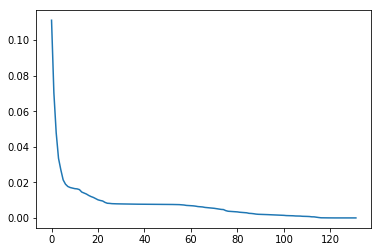

In [49]:
# Investigate the variance accounted for by each principal component.
plt.plot(pca.explained_variance_ratio_)
plt.show()


In [50]:
cummulated_variance = np.sum(pca.explained_variance_ratio_)
cummulated_variance

0.99999999999999989

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.

n_components = [10,20,50,60,80]

variance_ratio = []
n_cummulated_variance = []
n_cummulated_sum = []

for item in n_components:
    pca = PCA(n_components=item)
    result_pca = pca.fit_transform(scaled_data)
    variance_ratio.append(pca.explained_variance_ratio_)
    n_cummulated_variance.append(np.sum(pca.explained_variance_ratio_))
    
variance_df = pd.DataFrame()
variance_df['n_components'] = n_components
variance_df['variance_ratio'] = variance_ratio
variance_df['n_cummulated_variance'] = n_cummulated_variance


In [52]:
variance_df.head()

,n_components,variance_ratio,n_cummulated_variance
0,10,"[0.111181141436, 0.0704586370215, 0.0479067401...",0.381983
1,20,"[0.11118114143, 0.0704586364625, 0.04790672788...",0.517541
2,50,"[0.111181141436, 0.0704586370105, 0.0479067397...",0.757789
3,60,"[0.111181141436, 0.0704586370198, 0.0479067401...",0.832386
4,80,"[0.111181141436, 0.0704586370216, 0.0479067401...",0.939960


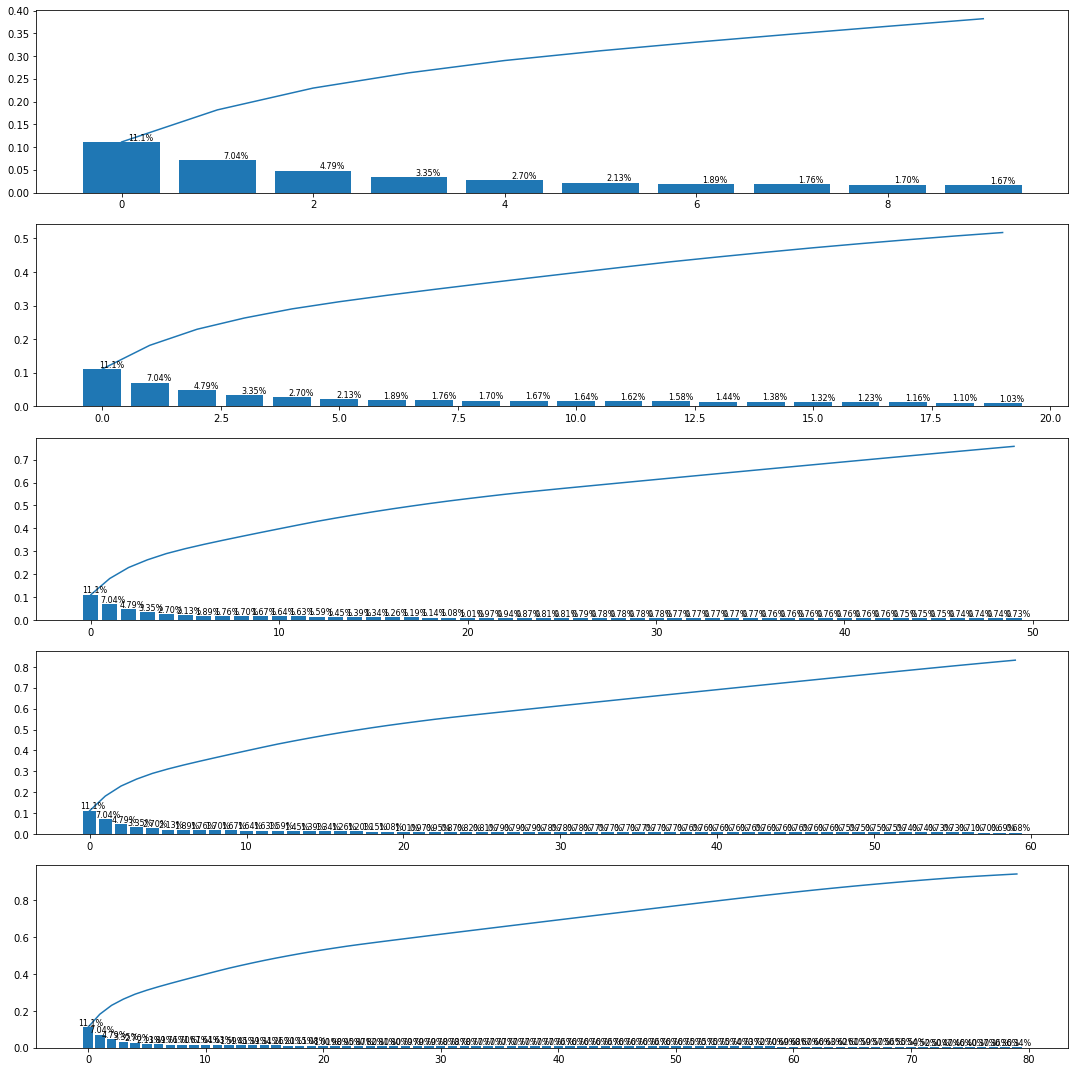

In [53]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,15))

for r_index,ax in enumerate(axes.flatten()):
    indices = np.arange(variance_df['n_components'][r_index])
    vals = variance_df['variance_ratio'][r_index]
    ax.bar(indices,vals)
    cumulated_sum = np.cumsum(vals)
    ax.plot(indices,cumulated_sum)
    for i in range(variance_df['n_components'][r_index]):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (indices[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
    
plt.tight_layout()
plt.show()

In [54]:
#final decided pca
# n_components = 80

pca = PCA(n_components=80)
result_pca = pca.fit_transform(scaled_data)
result_pca.shape

(771701, 80)

### Discussion 2.2: Perform Dimensionality Reduction


I initially started with no number of components passed to the PCA,after running the transformation it resulted in pca choosing all the features and the cummulated variance was 0.99 which is 99% of variability in data. Then I ran a loop on selected number of components to test which number of components will have high variability of features, I came to conclusion that when n_components is 80, then the total amount of variability will cover around 94% of my data.

Also after the initial pca, i looked at the elbow graph, and it suggested that the values become slowly decreasing after 80 components, so I will go with 80 components for the rest of this project


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [104]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def mapper(dataset,pca,p_components):
    components_df = pd.DataFrame(np.round(pca.components_, 4), columns = dataset.keys())
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    #new_df = pd.concat([variance_ratios,components_df],axis=1)
    print('Expalined Variance for component {} is {}'.format(p_components+1,variance_ratios.iloc[p_components][0]))
    print('Linked values sorted by weight for component {}\n'.format(p_components+1))
    display(components_df.loc[p_components,:].sort_values(ascending=False)) 
    

In [105]:
mapper(azdias_few_missing_values,pca,0)

Expalined Variance for component 1 is 0.1112
Linked values sorted by weight for component 1



PLZ8_ANTG3              0.1960
CAMEO_INTL_2015_TENS    0.1949
PLZ8_ANTG4              0.1902
HH_EINKOMMEN_SCORE      0.1890
PLZ8_BAUMAX             0.1859
ORTSGR_KLS9             0.1658
EWDICHTE                0.1637
FINANZ_HAUSBAUER        0.1561
KBA05_ANTG4             0.1337
PLZ8_ANTG2              0.1331
ARBEIT                  0.1241
ZABEOTYP                0.1229
KBA05_ANTG3             0.1199
ANZ_HAUSHALTE_AKTIV     0.1199
CAMEO_DEUG_2015_9       0.1180
RELAT_AB                0.1150
FINANZ_SPARER           0.0986
CAMEO_DEUG_2015_8       0.0982
SEMIO_PFLICHT           0.0701
SEMIO_REL               0.0665
CAMEO_DEU_2015_8A       0.0659
GEBAEUDETYP             0.0650
REGIOTYP                0.0644
CAMEO_DEU_2015_9C       0.0603
CAMEO_DEU_2015_9D       0.0598
CAMEO_DEU_2015_9B       0.0597
SEMIO_RAT               0.0577
decade                  0.0576
GFK_URLAUBERTYP         0.0556
W_KEIT_KIND_HH          0.0542
                         ...  
OST_WEST_KZ_W          -0.0513
CAMEO_DE

In [106]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

mapper(azdias_few_missing_values,pca,1)

Expalined Variance for component 2 is 0.0705
Linked values sorted by weight for component 2



ALTERSKATEGORIE_GROB     0.2666
FINANZ_VORSORGER         0.2386
SEMIO_ERL                0.2220
SEMIO_LUST               0.1856
RETOURTYP_BK_S           0.1629
W_KEIT_KIND_HH           0.1192
FINANZTYP                0.1190
FINANZ_MINIMALIST        0.1054
SHOPPER_TYP              0.1000
SEMIO_KRIT               0.0999
SEMIO_KAEM               0.0855
FINANZ_HAUSBAUER         0.0814
ANREDE_KZ                0.0688
WOHNDAUER_2008           0.0635
EWDICHTE                 0.0553
PLZ8_ANTG3               0.0546
ORTSGR_KLS9              0.0545
PLZ8_ANTG4               0.0516
SEMIO_DOM                0.0506
PLZ8_BAUMAX              0.0478
ARBEIT                   0.0446
CAMEO_INTL_2015_TENS     0.0417
KBA05_ANTG4              0.0410
CAMEO_DEU_2015_9E        0.0404
RELAT_AB                 0.0398
ANZ_HAUSHALTE_AKTIV      0.0381
PLZ8_ANTG2               0.0370
CAMEO_DEU_2015_8D        0.0365
CAMEO_DEUG_2015_8        0.0315
CAMEO_DEU_2015_6E        0.0261
                          ...  
LP_LEBEN

In [107]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

mapper(azdias_few_missing_values,pca,2)

Expalined Variance for component 3 is 0.0479
Linked values sorted by weight for component 3



SEMIO_VERT               0.3386
SEMIO_SOZ                0.2616
SEMIO_FAM                0.2552
SEMIO_KULT               0.2427
FINANZ_MINIMALIST        0.1535
FINANZTYP                0.1147
RETOURTYP_BK_S           0.0959
SEMIO_REL                0.0874
W_KEIT_KIND_HH           0.0812
FINANZ_VORSORGER         0.0791
SEMIO_MAT                0.0654
ALTERSKATEGORIE_GROB     0.0567
GREEN_AVANTGARDE         0.0548
movement                 0.0527
PLZ8_BAUMAX              0.0489
SEMIO_LUST               0.0477
ORTSGR_KLS9              0.0461
LP_STATUS_GROB           0.0454
PLZ8_ANTG4               0.0450
EWDICHTE                 0.0441
PLZ8_ANTG3               0.0433
ARBEIT                   0.0369
LP_STATUS_FEIN           0.0307
RELAT_AB                 0.0292
WOHNDAUER_2008           0.0278
PLZ8_ANTG2               0.0264
CAMEO_DEU_2015_9C        0.0246
OST_WEST_KZ_O            0.0243
CAMEO_INTL_2015_TENS     0.0241
CAMEO_DEUG_2015_9        0.0236
                          ...  
WOHNLAGE

### Discussion 2.3: Interpret Principal Components


Looking at the data, I can see that the first component shows just about 11.2% of variability in the data, component 2 about 7% and component 3 about 5%.Also after further analyzing the feature that contributes to most variablity in component 1 is PLZ8_ANTG3 which has weight of 0.1941, it can also be seen that the first 5 values are very close to each other and are positive so they which suggests that increase in one will also increase the others. 

Also the values at end of the components have negative sign which suggest that it has inverse relationship with the positive values, i.e. increase in the positive values at the top will result in large change in the weights of these features.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [109]:
# Over a number of different cluster counts...
centroids = np.arange(1,20)
my_scores = []
# run k-means clustering on the data and...
# compute the average within-cluster distances.
for cluster in centroids:
    kmean = KMeans(cluster)
    kmean.fit(result_pca)
    my_scores.append(np.abs(kmean.score(result_pca)))
      

Text(0.5,1,'SSE vs. K')

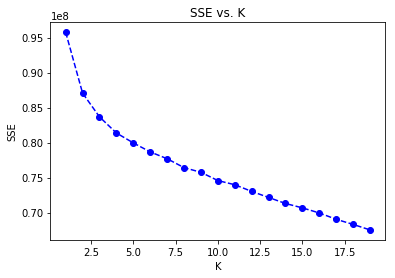

In [110]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centroids, my_scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [112]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmean = KMeans(17)
labels = kmean.fit_predict(result_pca)

In [113]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

I have decided to go with 17 clusters, as the sum of error was very low at this point. The algorithm was able to group the data into 17 groups starting from group 0 to group 16.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [111]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [114]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [117]:
cleaned_customers.shape

(141725, 132)

In [116]:
cleaned_customers = clean_data(customers)

In [118]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


filled_customers = imputer.transform(cleaned_customers)
scaled_customer_data = standard_scalar.transform(filled_customers)
pca_customers = pca.transform(scaled_customer_data)
customer_labels = kmean.predict(pca_customers)


In [110]:
# function no more used
def get_column_differences(df1,df2):
    return [col for col in df1.columns if col not in df2.columns]

In [119]:
np.unique(customer_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [120]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# renaming the variable
# because it will take time to retrain
general_population_data = labels


In [121]:
print('Records in General Population is {}'.format(general_population_data.shape[0]))
print('Records in Customer Data is {}'.format(customer_labels.shape[0]))

Records in General Population is 771701
Records in Customer Data is 141725


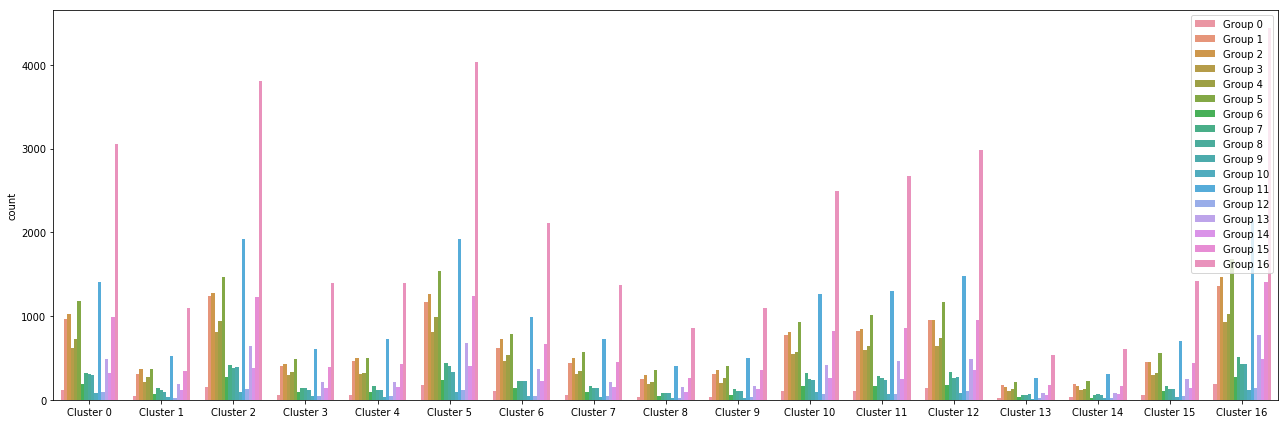

In [124]:
# comparing first 141725 records or general population
# with customer data

general_population_subset = general_population_data[:customer_labels.shape[0]]

# initial exploration of the data

groups = []
clusters = []
for i in range(17):
    groups.append('Group {}'.format(i))

for i in range(17):
    clusters.append('Cluster {}'.format(i))
    
x_labels = np.arange(17)    
#default_color = sns.color_palette()[0]
plt.figure(figsize=(18,6))
sns.countplot(general_population_subset,hue=customer_labels)
plt.legend(loc='upper right',labels=groups)
plt.xticks(x_labels,clusters)
plt.tight_layout()
plt.show()

In [125]:
general_population_subset[:5]

array([12,  0, 14,  5,  0], dtype=int32)

In [126]:
general_subset_proportion = []
customers_proportion = []
for i in range(17):
    general_subset_proportion.append((general_population_subset == i).sum() / general_population_subset.shape[0])
    customers_proportion.append((customer_labels == i).sum() / customer_labels.shape[0])

proportions_df = pd.DataFrame()
proportions_df['general_subset_proportion'] = general_subset_proportion
proportions_df['customer_data_proportions'] = customers_proportion
proportions_df['difference'] = np.subtract(general_subset_proportion , customers_proportion)

proportions_df.head(17)

,general_subset_proportion,customer_data_proportions,difference
0,0.086117,0.010549,0.075569
1,0.030587,0.076867,-0.046280
2,0.109734,0.081799,0.027934
3,0.037820,0.052552,-0.014733
4,0.039633,0.059961,-0.020328
5,0.111787,0.094923,0.016864
6,0.059799,0.015897,0.043902
7,0.040656,0.027821,0.012835
8,0.024301,0.024583,-0.000282
9,0.030178,0.023595,0.006583


In [127]:
# maximum value of the data
max_value = proportions_df.max().sort_values(ascending=False)[0]

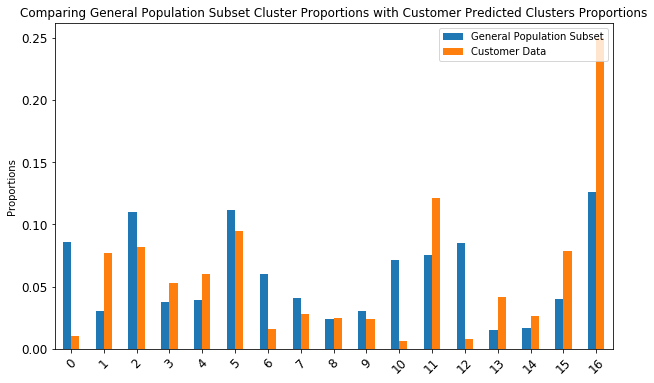

In [128]:
ax = proportions_df[['general_subset_proportion','customer_data_proportions']].plot(kind='bar', title ="Comparing General Population Subset Cluster Proportions with Customer Predicted Clusters Proportions", figsize=(10, 6), legend=True, fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper right',labels=['General Population Subset','Customer Data'])
plt.ylabel('Proportions')
plt.show()

In [129]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over_represented_pca = pca_customers[customer_labels == 16]
reversed_data = standard_scalar.inverse_transform(pca.inverse_transform(over_represented_pca))

over_represented_customers = pd.DataFrame(data=reversed_data,
            columns=cleaned_customers.columns)

over_represented_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,3.538911,1.090296,1.560921,5.345512,0.647549,5.251238,1.648888,0.843469,2.129352,5.956426,...,-0.002237,0.007990,0.005658,0.004701,-0.014068,1.014068,2.542100,-0.043372,2.067335,3.978684
1,3.038325,1.072672,4.046120,4.691962,0.869134,5.369964,0.803883,1.570977,3.077725,4.634803,...,-0.000109,-0.009368,-0.022190,-0.003164,-0.066416,1.066416,2.786013,1.028479,2.818745,4.067991
2,3.383751,1.001996,6.394732,4.805717,2.275746,3.685569,2.122903,3.218073,0.823562,2.524759,...,-0.005452,0.004250,-0.017632,0.000248,-0.051988,1.051988,4.600658,0.023827,3.853327,3.033704
3,3.995312,2.010897,4.010887,2.467814,2.402808,4.323827,3.017565,2.877510,3.911470,2.170663,...,-0.008526,0.006519,0.023781,0.004418,-0.123000,1.123000,3.916056,-0.010182,2.013756,4.004255
4,4.248970,1.181626,5.924398,4.758057,2.388385,3.537967,1.996679,3.303459,1.238080,3.234229,...,-0.014854,-0.001808,0.029622,-0.001967,-0.058606,1.058606,3.943890,1.019806,2.975728,2.977022


In [130]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

under_represented_pca = pca_customers[customer_labels == 12]
reversed_data_underrepresented = standard_scalar.inverse_transform(pca.inverse_transform(under_represented_pca))

under_represented_customers = pd.DataFrame(data=reversed_data_underrepresented,
            columns=cleaned_customers.columns)

under_represented_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,1.560741,1.939475,1.912914,2.365336,1.733910,4.148651,2.180144,0.457337,5.393230,6.020183,...,0.002131,-0.003295,0.994503,-0.000810,0.933281,0.066719,3.182782,-0.018969,4.987046,0.979630
1,2.129650,1.930104,4.120441,2.317147,1.940940,5.291127,2.155948,1.722399,5.634387,2.330849,...,0.000870,-0.007607,0.012410,0.003602,0.008179,0.991821,2.546823,0.000044,5.006169,1.029434
2,2.100037,1.968308,6.173917,0.904236,4.581901,1.849836,5.054818,3.569371,5.263599,1.487253,...,0.013757,-0.006712,-0.015105,-0.001642,0.975492,0.024508,4.955135,0.139784,4.975058,4.006541
3,1.047779,1.753661,1.929271,2.765625,1.430405,4.442767,2.169487,0.249904,5.188218,5.646607,...,0.023368,-0.007505,0.961048,-0.000921,0.992112,0.007888,3.620289,-0.052588,4.969061,1.053161
4,1.443075,2.035908,3.688135,1.117376,4.121426,2.490617,3.391569,3.959453,3.968209,1.310538,...,-0.004185,0.010136,-0.001062,-0.000084,0.008753,0.991247,5.782139,-0.013114,4.972743,3.962383


### Discussion 3.3: Compare Customer Data to Demographics Data


I have looked at subset of data from general population dataset with customer data, the results that i have found are as follows:

People belonging to cluster 1,3,4,8,11,13,14,15,16 are our target audience because their proportion is higher compared to general population and are popular with mail-order company. 16 is the highest cluster to hold the maximum proportion of customers

People belonging to cluster 0,2,5,6,7,9,10,12 are people outside the target demographics and can be considered as unpopular with the mail company

I also noticed that after doing inverse transform and mapping them to columns, i got the same values back that were scaled down

Also after further analysis, i found that in under rated customers, the values returned back were lower than the actual values, for example "ALTERSKATEGORIE_GROB" top 5 actual values for first record is 4, so i got value of around 4 for over represented customers, and I got value between 1-2 for top 5 values of under rated customers

We might be able to remove the users that have different values than the actual values and we will get the summary of users that we are interesed in

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.